# imports

In [1]:
! pip install dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.6/192.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.4 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12


In [2]:
!pip install scikit-learn==1.4.2
# dowhy requires an older version of sklearn
import sklearn
print(sklearn.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
1.4.2


In [3]:
import pandas as pd
import dowhy
from dowhy.gcm.ml.classification import SklearnClassificationModel

from dowhy import CausalModel, gcm
import networkx as nx
import numpy as np
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# load data

In [5]:
data_orig = pd.read_csv("/content/drive/MyDrive/Spring 2025/ML and Climate/wildfire_project/long_2000_mean_fire_earth_data.csv")

In [6]:
# print(data_orig.columns.tolist())
# drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100']
# data = data_orig.drop(columns=drop_cols)
# drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE',   'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE',  'date', 'dead_fuel_100', 'dead_fuel_1000']

# data_class = data_orig.drop(columns=drop_cols)
# data_class['FIRE_SIZE_CLASS'].unique()
# mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
# data_class['FIRE_SIZE_CLASS_NUM'] = data_class['FIRE_SIZE_CLASS'].map(mapping)
# data_class = data_class.drop(columns=['FIRE_SIZE_CLASS'])
# data_class = data_class.dropna()
# data_class




print(data_orig.columns.tolist())


# drop unused variables
# drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100']
# drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100']
drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE', 'FIRE_YEAR', 'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'date', 'dead_fuel_100', 'dead_fuel_1000', 'CONT_DATE', 'DURATION_DAYS', 'energy_release', 'DISCOVERY_DOY' ]
# drop_cols = ['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE',  'DISCOVERY_DATE', 'STAT_CAUSE_DESCR', 'STATE',  'date', 'dead_fuel_100']

data_class = data_orig.drop(columns=drop_cols)

# make the prediction numeric instead of alphabetic
data_class['FIRE_SIZE_CLASS'].unique()
mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
# data_class['FIRE_SIZE_CLASS_NUM'] = data_class['FIRE_SIZE_CLASS'].map(mapping)
# data_class = data_class.drop(columns=['FIRE_SIZE_CLASS'])


data_class['temp_C'] = (data_class['min_temp_C'] + data_class['max_temp_C'])/2
data_class = data_class.drop(columns=['min_temp_C', 'max_temp_C'])

# drop invalid rows
data_class = data_class.dropna()

data_class


['FOD_ID', 'FIRE_NAME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'FIRE_YEAR', 'DISCOVERY_DATE', 'CONT_DATE', 'DURATION_DAYS', 'STAT_CAUSE_DESCR', 'STATE', 'LATITUDE', 'LONGITUDE', 'DISCOVERY_DOY', 'date', 'dead_fuel_100', 'dead_fuel_1000', 'energy_release', 'humidity', 'max_temp_C', 'min_temp_C', 'precipitation', 'wind_speed', 'population_density', 'vegetation', 'drought_index']


,FIRE_SIZE_CLASS,humidity,precipitation,wind_speed,population_density,vegetation,drought_index,temp_C
0,A,0.004474,0.0,2.230986,0.000000,2384.0,-2.6175,14.140283
1,A,0.004474,0.0,2.230986,0.000000,2384.0,-2.6175,14.140283
2,G,0.004487,0.0,2.096183,0.000000,2080.0,-3.6375,16.809213
3,G,0.003525,0.0,3.542572,0.546957,1560.0,-3.3975,16.375116
4,B,0.003591,0.0,3.919152,0.325217,1913.0,0.4950,19.761011
...,...,...,...,...,...,...,...,...
61195,A,0.006939,0.0,2.236683,0.372284,1549.0,-3.9650,23.547144
61196,E,0.005318,0.0,3.303576,0.498421,1872.0,-4.7675,25.114221
61197,A,0.007447,0.0,3.026281,8.687964,1662.0,-5.6475,30.048593
61198,C,0.004246,0.0,2.567572,40.920891,2493.0,-3.8075,32.517709


In [ ]:

print(data.shape[0])
data = data.dropna()
print(data.shape[0])

61200
58241


In [ ]:
data_np = data.to_numpy()

# causal model

# many iterations of graph testing (ultimatley graphs unused)

## unused

In [ ]:
causal_graph1 = """
digraph {
    humidity -> FIRE_SIZE;
    precipitation -> FIRE_SIZE;
    wind_speed -> FIRE_SIZE;
    drought_index -> FIRE_SIZE;
    dead_fuel_1000 -> FIRE_SIZE;
    energy_release -> FIRE_SIZE;
    max_temp_C -> FIRE_SIZE;
    min_temp_C -> FIRE_SIZE;
    vegetation -> FIRE_SIZE;
    population_density -> FIRE_SIZE;
    drought_index -> dead_fuel_1000;
}
"""


In [ ]:
# model = CausalModel(
#     data=data,
#     treatment=['humidity', 'precipitation', 'wind_speed', 'dead_fuel_1000', 'drought_index'],
#     outcome='FIRE_SIZE',
#     graph=causal_graph1
# )

# # Visualize the model
# model.view_model()

# # Identify causal effect
# identified_estimand = model.identify_effect()

# # Estimate causal effect
# causal_estimate = model.estimate_effect(
#     identified_estimand,
#     method_name="backdoor.linear_regression"
# )

# print(causal_estimate)


## first pass

In [ ]:
causal_graph = nx.DiGraph([
    ('humidity','FIRE_SIZE'),
    ('humidity','dead_fuel_1000'),
    ('precipitation','FIRE_SIZE'),
    ('precipitation','humidity'),
    ('precipitation','drought_index'),
    ('precipitation','vegetation'),
    ('wind_speed','FIRE_SIZE'),
     ('drought_index','FIRE_SIZE'),
      ('drought_index','energy_release'),
       ('drought_index','vegetation'),
        ('dead_fuel_1000','FIRE_SIZE'),
         ('dead_fuel_1000','energy_release'),
          ('energy_release','FIRE_SIZE'),
           ('max_temp_C','humidity'),
           ('max_temp_C','drought_index'),
            ('min_temp_C','humidity'),
             ('vegetation','dead_fuel_1000'),
              ('population_density','FIRE_SIZE'),
               ('population_density','vegetation'),
                ('drought_index','dead_fuel_1000'),
                 ('drought_index','vegetation')
])

In [ ]:
causal_model = gcm.StructuralCausalModel(causal_graph)


In [ ]:
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data)


In [ ]:
print(auto_assignment_summary)


When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In [ ]:
gcm.fit(causal_model, data)


Fitting causal mechanism of node population_density: 100%|██████████| 11/11 [00:03<00:00,  2.96it/s]


Test permutations of given graph: 100%|██████████| 50/50 [05:26<00:00,  6.52s/it]


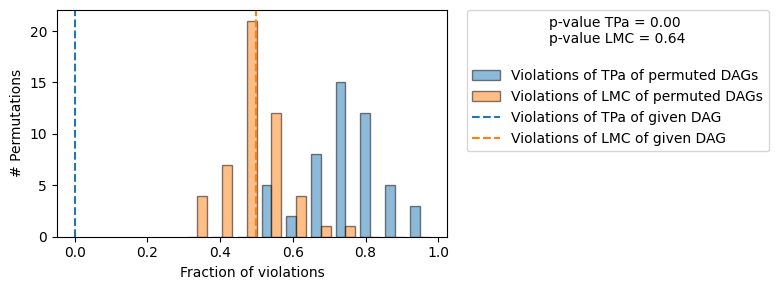

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
print(gcm.evaluate_causal_model(causal_model, data))


## second try


In [ ]:
causal_graph = nx.DiGraph([
    ('humidity','FIRE_SIZE'),
    ('humidity','dead_fuel_1000'),

    ('precipitation','FIRE_SIZE'),
    ('precipitation','humidity'),
    ('precipitation','drought_index'),

    ('wind_speed','FIRE_SIZE'),

    ('drought_index','FIRE_SIZE'),
    ('drought_index','energy_release'),

    ('dead_fuel_1000','FIRE_SIZE'),
    ('dead_fuel_1000','energy_release'),

    ('energy_release','FIRE_SIZE'),

    ('max_temp_C','drought_index'),

    ('min_temp_C','humidity'),

    ('vegetation','dead_fuel_1000'),

    ('population_density','FIRE_SIZE'),
    ('population_density','vegetation'),

    ('drought_index','dead_fuel_1000'),
    ('drought_index','vegetation')
])

In [ ]:
causal_model = gcm.StructuralCausalModel(causal_graph)


In [ ]:
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data)


In [ ]:
gcm.fit(causal_model, data)


Fitting causal mechanism of node population_density: 100%|██████████| 11/11 [00:04<00:00,  2.52it/s]


Test permutations of given graph: 100%|██████████| 50/50 [05:00<00:00,  6.01s/it]


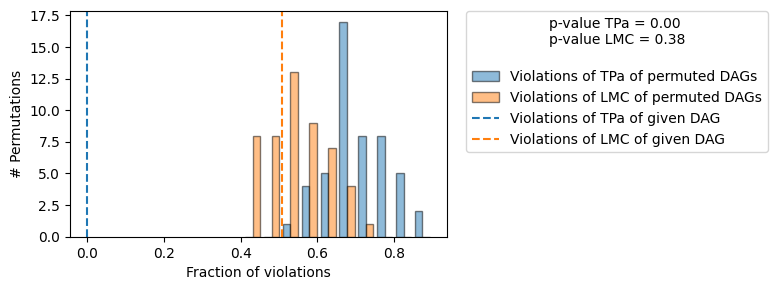

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
print(gcm.evaluate_causal_model(causal_model, data))


## next iteration

In [ ]:
causal_graph = nx.DiGraph([
    ('humidity','FIRE_SIZE'),
    ('humidity','dead_fuel_1000'),
    ('humidity', 'vegetation'),

    ('precipitation','humidity'),
    ('precipitation','drought_index'),
    ('precipitation','dead_fuel_1000'),

    ('wind_speed','energy_release'),

    ('drought_index','FIRE_SIZE'),
    ('drought_index','energy_release'),

    ('dead_fuel_1000','FIRE_SIZE'),
    ('dead_fuel_1000','energy_release'),

    ('energy_release','FIRE_SIZE'),

    ('max_temp_C','drought_index'),

    ('min_temp_C','humidity'),

    ('vegetation','dead_fuel_1000'),
    ('vegetation','FIRE_SIZE'),

    ('population_density','FIRE_SIZE'),
    ('population_density','vegetation'),

    ('drought_index','dead_fuel_1000'),
    ('drought_index','vegetation')
])

causal_model = gcm.StructuralCausalModel(causal_graph)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data)
gcm.fit(causal_model, data)
print(gcm.evaluate_causal_model(causal_model, data))


Fitting causal mechanism of node population_density: 100%|██████████| 11/11 [00:04<00:00,  2.29it/s]
Evaluating causal mechanisms...: 100%|██████████| 11/11 [01:25<00:00,  7.75s/it]


Fitting causal mechanism of node population_density: 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]
Test permutations of given graph: 100%|██████████| 50/50 [02:12<00:00,  2.66s/it]


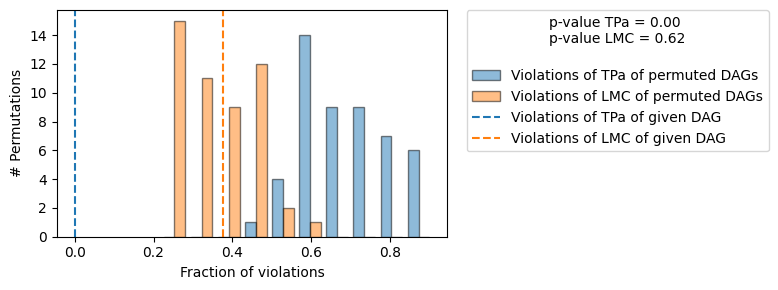

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
# another iteration

causal_graph = nx.DiGraph([
    ('humidity','FIRE_SIZE'),
    ('humidity','dead_fuel_1000'),

    ('precipitation','humidity'),
    ('precipitation','drought_index'),
    ('precipitation','dead_fuel_1000'),

    ('wind_speed','energy_release'),

    ('dead_fuel_1000','FIRE_SIZE'),
    ('dead_fuel_1000','energy_release'),

    ('energy_release','FIRE_SIZE'),

    ('population_density','FIRE_SIZE'),
])

causal_model = gcm.StructuralCausalModel(causal_graph)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data)
gcm.fit(causal_model, data)
print(gcm.evaluate_causal_model(causal_model, data))


## classification


In [ ]:
causal_graph = nx.DiGraph([
    ('humidity','FIRE_SIZE_CLASS_NUM'),
    ('humidity','dead_fuel_1000'),
    ('humidity', 'vegetation'),

    ('precipitation','humidity'),
    ('precipitation','drought_index'),
    ('precipitation','dead_fuel_1000'),

    ('wind_speed','energy_release'),

    ('drought_index','FIRE_SIZE_CLASS_NUM'),
    ('drought_index','energy_release'),

    ('dead_fuel_1000','FIRE_SIZE_CLASS_NUM'),
    ('dead_fuel_1000','energy_release'),

    ('energy_release','FIRE_SIZE_CLASS_NUM'),

    ('max_temp_C','drought_index'),

    ('min_temp_C','humidity'),

    ('vegetation','dead_fuel_1000'),
    ('vegetation','FIRE_SIZE_CLASS_NUM'),

    ('population_density','FIRE_SIZE_CLASS_NUM'),
    ('population_density','vegetation'),

    ('drought_index','dead_fuel_1000'),
    ('drought_index','vegetation')
])

causal_model = gcm.StructuralCausalModel(causal_graph)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data_class)

gcm.fit(causal_model, data_class)
print(gcm.evaluate_causal_model(causal_model, data_class))



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 1650, in _get_outputs
    yield from self._retrieve()
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 1762, in _retrieve
    time.sleep(0.01)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-276404cf1872>", line 35, in <cell line: 0>
    auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data_class)
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/dowhy/gcm/auto.py", line 294, in assign_causal_mechanisms
    model_performances = assign_causal_mechanism_node(causal_model, node, based_on, q

TypeError: object of type 'NoneType' has no len()

## next iteration

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Test permutations of given graph: 100%|██████████| 6/6 [00:00<00:00, 536.21it/s]


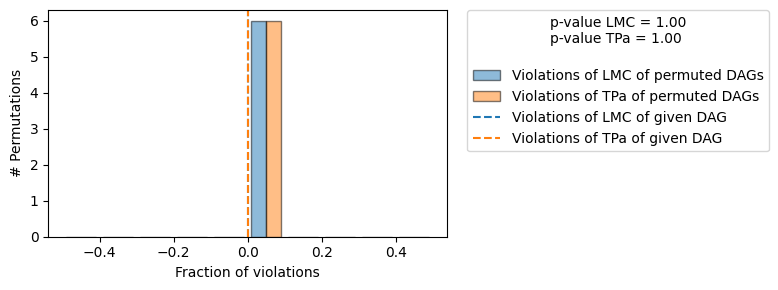

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
# same graph, but more complicated mechanisms

causal_graph = nx.DiGraph([
    ('humidity','FIRE_SIZE_CLASS_NUM'),
    ('humidity','dead_fuel_1000'),
    ('humidity', 'vegetation'),

    ('precipitation','humidity'),
    ('precipitation','drought_index'),
    ('precipitation','dead_fuel_1000'),

    ('wind_speed','energy_release'),

    ('drought_index','FIRE_SIZE_CLASS_NUM'),
    ('drought_index','energy_release'),

    ('dead_fuel_1000','FIRE_SIZE_CLASS_NUM'),
    ('dead_fuel_1000','energy_release'),

    ('energy_release','FIRE_SIZE_CLASS_NUM'),

    ('max_temp_C','drought_index'),

    ('min_temp_C','humidity'),

    ('vegetation','dead_fuel_1000'),
    ('vegetation','FIRE_SIZE_CLASS_NUM'),

    ('population_density','FIRE_SIZE_CLASS_NUM'),
    ('population_density','vegetation'),

    ('drought_index','dead_fuel_1000'),
    ('drought_index','vegetation')
])
# causal_graph = nx.DiGraph([
#     ('humidity','FIRE_SIZE_CLASS_NUM'),
#     ('humidity', 'vegetation'),

#     ('vegetation','FIRE_SIZE_CLASS_NUM'),

# ])

causal_model = gcm.StructuralCausalModel(causal_graph)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data_class)
print(auto_assignment_summary)
gcm.fit(causal_model, data_class)
print(gcm.evaluate_causal_model(causal_model, data_class))



# causal discovery

In [ ]:
from causallearn.search.ConstraintBased.PC import pc

labels = [f'{col}' for i, col in enumerate(data.columns)]
data_np = data.to_numpy()

cg = pc(data_np)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(cg.G, labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

AssertionError: Input data contains NaN. Please check.

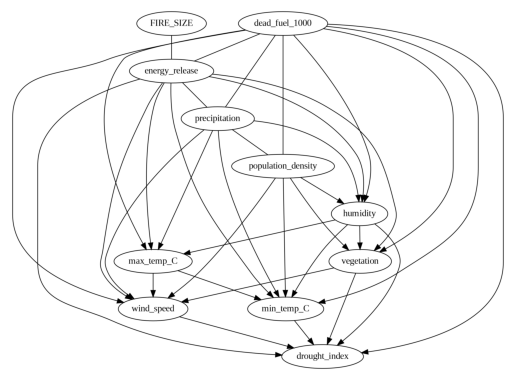

In [ ]:
from causallearn.search.ScoreBased.GES import ges

# default parameters
Record = ges(data_np)

# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'], labels=labels)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

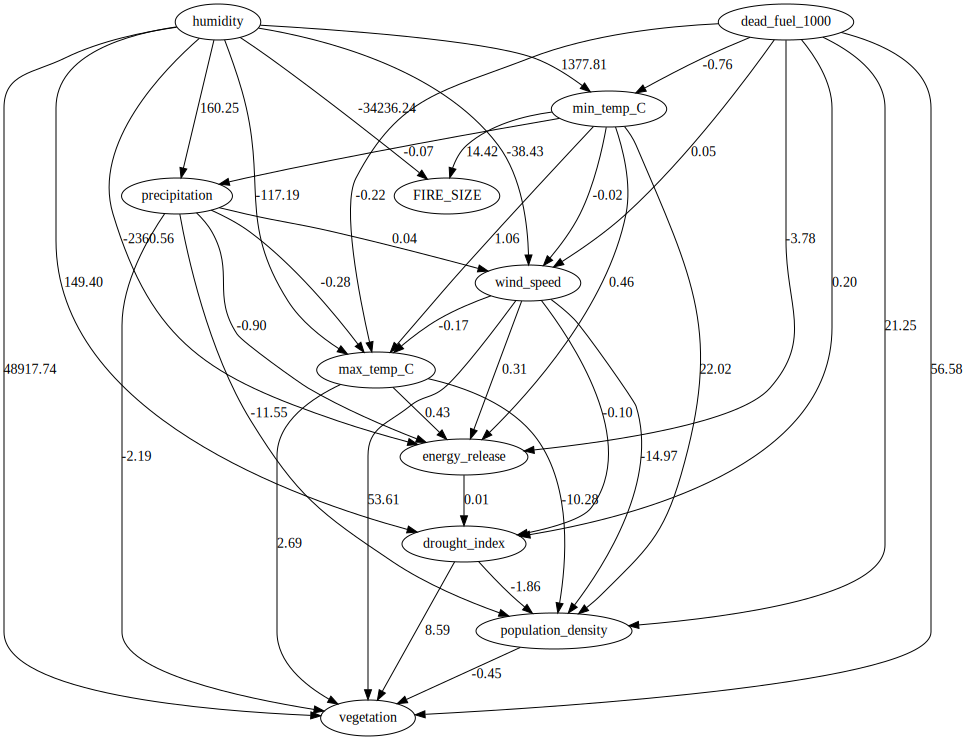

In [ ]:
from causallearn.search.FCMBased import lingam
model = lingam.ICALiNGAM()
model.fit(data_np)

from causallearn.search.FCMBased.lingam.utils import make_dot
make_dot(model.adjacency_matrix_, labels=labels)

# ultimately selected graph

### with max temp

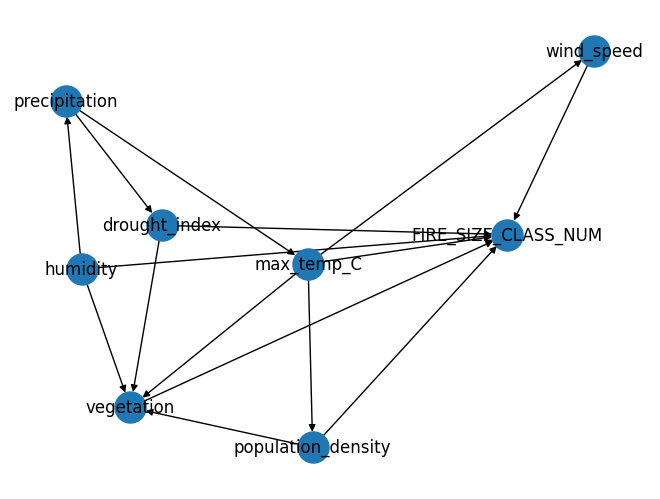

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Fitting causal mechanism of node population_density: 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]
Test permutations of given graph: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


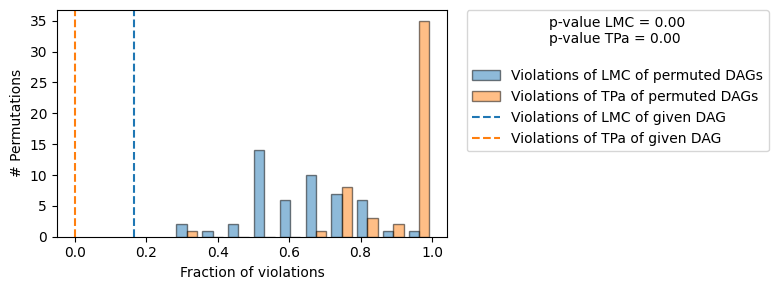

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
#

causal_graph = nx.DiGraph([

    ('humidity','FIRE_SIZE_CLASS_NUM'),
    ('humidity', 'vegetation'),
    ('humidity', 'precipitation'),

    ('precipitation','drought_index'),
    ('precipitation','max_temp_C'),

    ('wind_speed','FIRE_SIZE_CLASS_NUM'),

    ('drought_index','FIRE_SIZE_CLASS_NUM'),

    ('max_temp_C','FIRE_SIZE_CLASS_NUM'),
    ('max_temp_C','vegetation'),
    ('max_temp_C','population_density'),
    ('max_temp_C','wind_speed'),

    ('vegetation','FIRE_SIZE_CLASS_NUM'),

    ('population_density','FIRE_SIZE_CLASS_NUM'),
    ('population_density','vegetation'),

    ('drought_index','vegetation'),
])

nx.draw(causal_graph, with_labels=True, node_size=500, arrows=True)
plt.show()


causal_model = gcm.StructuralCausalModel(causal_graph)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data_class)
print(auto_assignment_summary)
gcm.fit(causal_model, data_class)
print(gcm.evaluate_causal_model(causal_model, data_class))


### with med temp

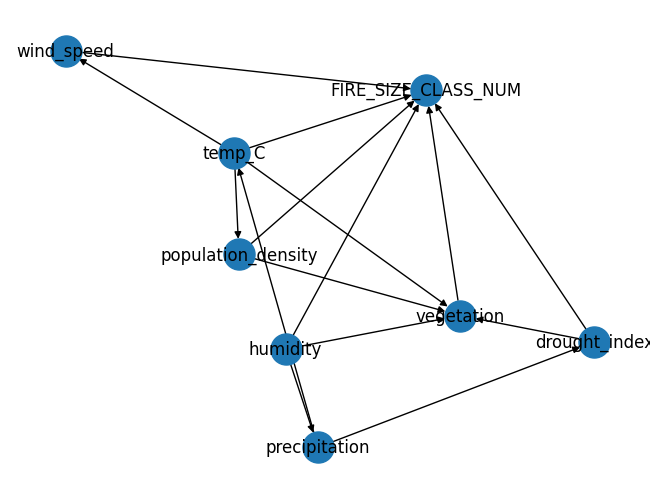

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Fitting causal mechanism of node population_density: 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]
Test permutations of given graph: 100%|██████████| 50/50 [01:31<00:00,  1.83s/it]


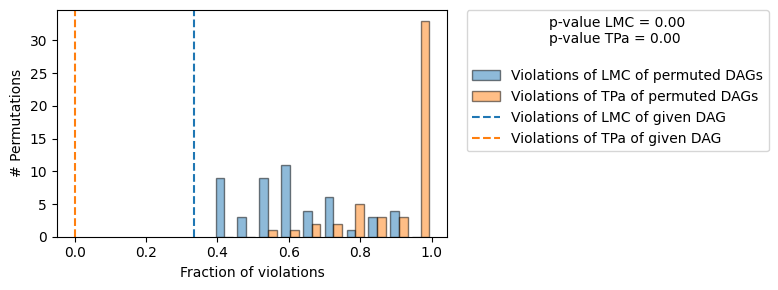

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [ ]:
# with merged temp

causal_graph = nx.DiGraph([

    ('humidity','FIRE_SIZE_CLASS_NUM'),
    ('humidity', 'vegetation'),
    ('humidity', 'precipitation'),

    ('precipitation','drought_index'),
    ('precipitation','temp_C'),

    ('wind_speed','FIRE_SIZE_CLASS_NUM'),

    ('drought_index','FIRE_SIZE_CLASS_NUM'),

    ('temp_C','FIRE_SIZE_CLASS_NUM'),
    ('temp_C','vegetation'),
    ('temp_C','population_density'),
    ('temp_C','wind_speed'),

    ('vegetation','FIRE_SIZE_CLASS_NUM'),

    ('population_density','FIRE_SIZE_CLASS_NUM'),
    ('population_density','vegetation'),

    ('drought_index','vegetation'),
])

nx.draw(causal_graph, with_labels=True, node_size=500, arrows=True)
plt.show()


causal_model = gcm.StructuralCausalModel(causal_graph)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data_class)
print(auto_assignment_summary)
gcm.fit(causal_model, data_class)
print(gcm.evaluate_causal_model(causal_model, data_class))


# categorical

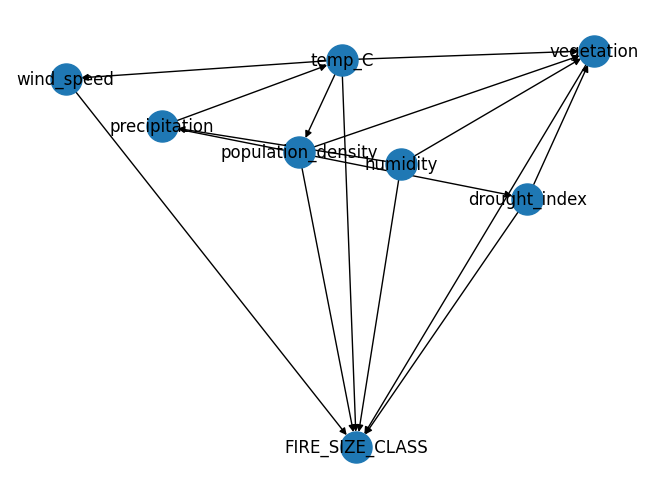

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Fitting causal mechanism of node population_density: 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]
Test permutations of given graph: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


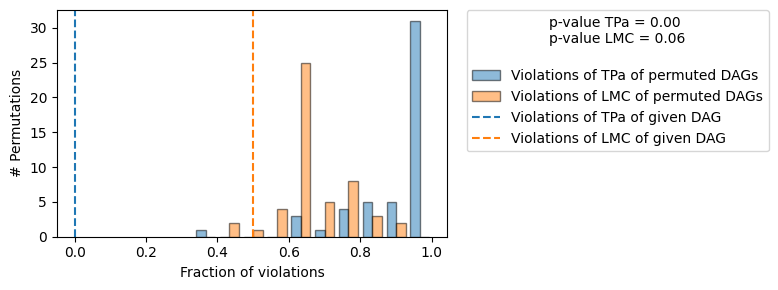

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [8]:
# with merged temp

causal_graph = nx.DiGraph([

    ('humidity','FIRE_SIZE_CLASS'),
    ('humidity', 'vegetation'),
    ('humidity', 'precipitation'),

    ('precipitation','drought_index'),
    ('precipitation','temp_C'),

    ('wind_speed','FIRE_SIZE_CLASS'),

    ('drought_index','FIRE_SIZE_CLASS'),

    ('temp_C','FIRE_SIZE_CLASS'),
    ('temp_C','vegetation'),
    ('temp_C','population_density'),
    ('temp_C','wind_speed'),

    ('vegetation','FIRE_SIZE_CLASS'),

    ('population_density','FIRE_SIZE_CLASS'),
    ('population_density','vegetation'),

    ('drought_index','vegetation'),
])

nx.draw(causal_graph, with_labels=True, node_size=500, arrows=True)
plt.show()


causal_model = gcm.StructuralCausalModel(causal_graph)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data_class)
print(auto_assignment_summary)
gcm.fit(causal_model, data_class)
print(gcm.evaluate_causal_model(causal_model, data_class))
